In [61]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras_visualizer import visualizer 
from IPython.display import Image, display

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Loading dataset

In [62]:
RANDOM_SEED = 42

dataset = glob("data/gestures/*.csv")
model_save_path = 'model/gesture_classifier.hdf5'
tflite_save_path = 'model/gesture_classifier.tflite'

NUM_CLASSES = 10

smallest = min([sum(1 for _ in open(f)) for f in dataset])

X_dataset = np.concatenate([np.loadtxt(f, delimiter=',', dtype='float32', usecols=list(
    range(1, (21 * 2) + 1)), max_rows=smallest) for f in dataset])

y_dataset = np.concatenate(
    [np.loadtxt(f, delimiter=',', dtype='int32', usecols=(0), max_rows=smallest) for f in dataset])

X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)


# Model building

In [63]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=100, verbose=1)

# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()  

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_19 (Dropout)        (None, 42)                0         
                                                                 
 dense_27 (Dense)            (None, 80)                3440      
                                                                 
 dropout_20 (Dropout)        (None, 80)                0         
                                                                 
 dense_28 (Dense)            (None, 40)                3240      
                                                                 
 dropout_21 (Dropout)        (None, 40)                0         
                                                                 
 dense_29 (Dense)            (None, 20)                820       
                                                                 
 dense_30 (Dense)            (None, 10)               

# Model visualization

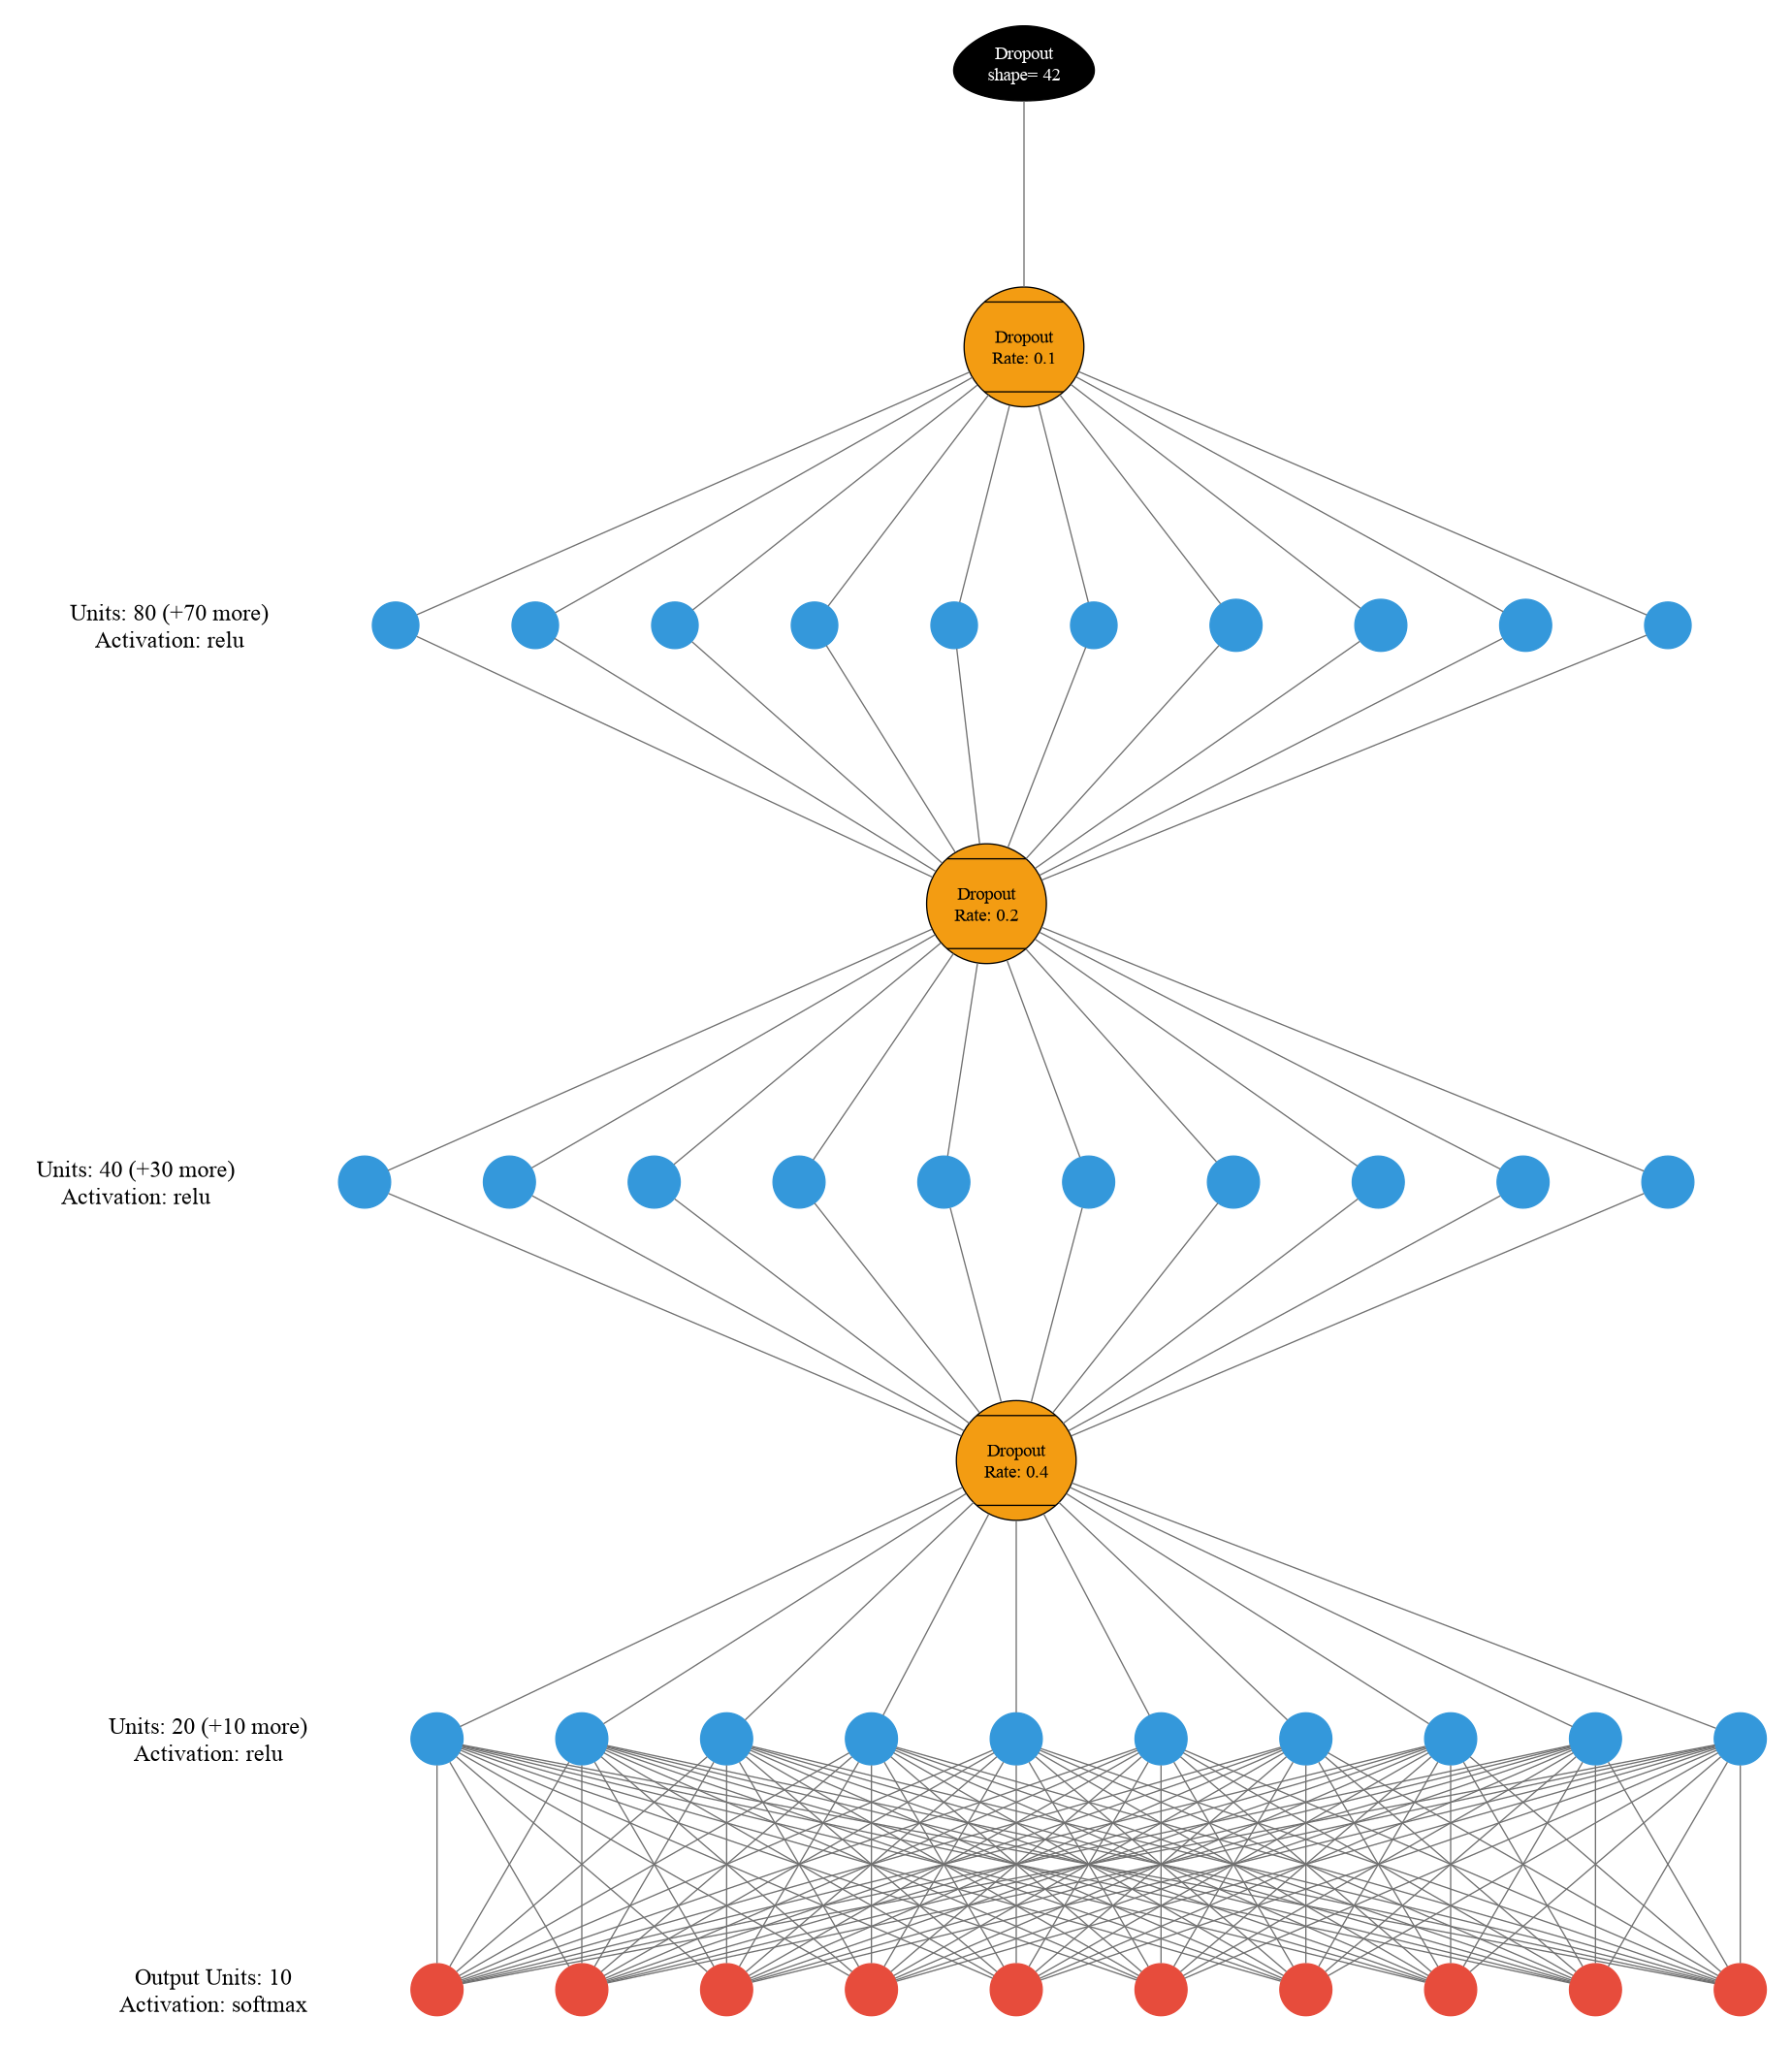

In [64]:
visualizer(model, file_name='network', file_format="png", view=False)
display(Image(filename='network.png', width=1000) )
os.remove('network')
os.remove('network.png')

# Model training

In [69]:
result = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
89/89 [==============================] - 0s 1ms/step - loss: 0.3108 - accuracy: 0.8965 - val_loss: 0.1321 - val_accuracy: 0.9652
Epoch 2/1000
89/89 [==============================] - 0s 1ms/step - loss: 0.3162 - accuracy: 0.8926 - val_loss: 0.1308 - val_accuracy: 0.9636
Epoch 3/1000
89/89 [==============================] - 0s 1ms/step - loss: 0.3107 - accuracy: 0.9004 - val_loss: 0.1386 - val_accuracy: 0.9593
Epoch 4/1000
89/89 [==============================] - 0s 2ms/step - loss: 0.3036 - accuracy: 0.8994 - val_loss: 0.1292 - val_accuracy: 0.9659
Epoch 5/1000
89/89 [==============================] - 0s 1ms/step - loss: 0.3034 - accuracy: 0.8946 - val_loss: 0.1232 - val_accuracy: 0.9712
Epoch 6/1000
89/89 [==============================] - 0s 1ms/step - loss: 0.3093 - accuracy: 0.8979 - val_loss: 0.1178 - val_accuracy: 0.9712
Epoch 7/1000
89/89 [==============================] - 0s 2ms/step - loss: 0.3037 - accuracy: 0.9012 - val_loss: 0.1231 - val_accuracy: 0.9691
Epoch 

# Model evaluation

30/30 [==============================] - 0s 356us/step - loss: 0.1407 - accuracy: 0.9644


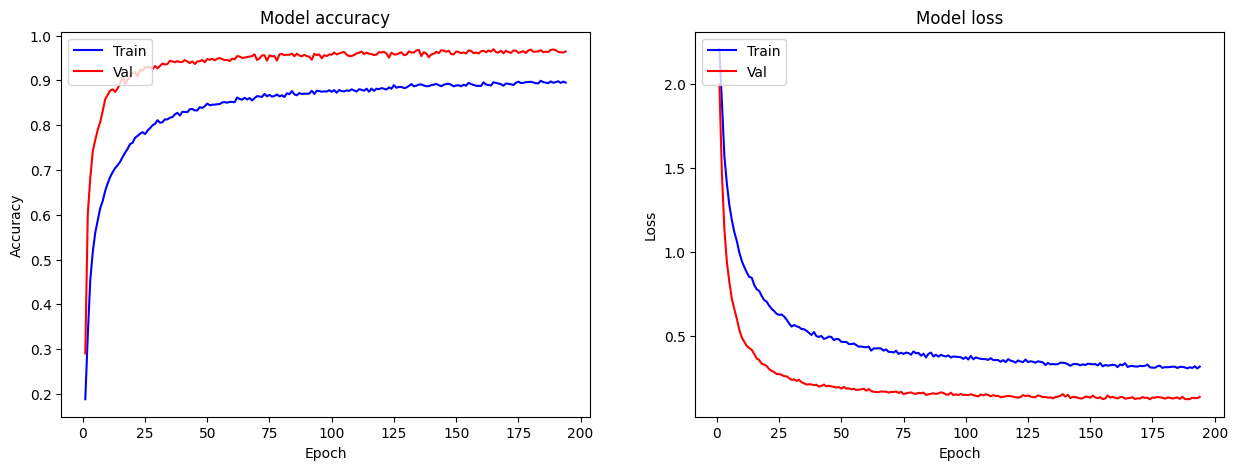

In [66]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

acc = result.history['accuracy']
val_acc = result.history['val_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

# Confusion matrix

119/119 [==============================] - 0s 419us/step


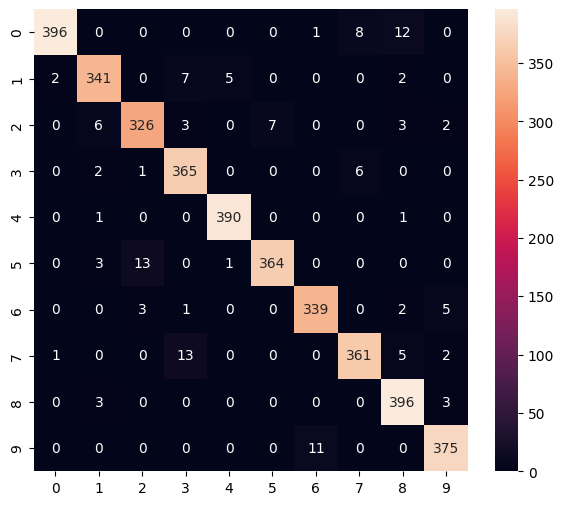

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       417
           1       0.96      0.96      0.96       357
           2       0.95      0.94      0.94       347
           3       0.94      0.98      0.96       374
           4       0.98      0.99      0.99       392
           5       0.98      0.96      0.97       381
           6       0.97      0.97      0.97       350
           7       0.96      0.95      0.95       382
           8       0.94      0.99      0.96       402
           9       0.97      0.97      0.97       386

    accuracy                           0.96      3788
   macro avg       0.96      0.96      0.96      3788
weighted avg       0.96      0.96      0.96      3788



In [67]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Saving model as Tensorflow-Lite

In [68]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpu_wd2zib/assets


INFO:tensorflow:Assets written to: /tmp/tmpu_wd2zib/assets


13864